# Q-learning

## Q의 정의
* $Q(s, a)$ : state $s$에서 action $a$를 취하고, 그다음부터는 $\pi$정책을 따라갈 때 총 보상 $R$의 기대값
  * $\pi(s)$: $argmax_a Q(s,a)$

## 구하는 법
$$Q(s,a) = E_{s' \sim p(s'|s,a)}[r(s,a) + \gamma \cdot V(s')]$$

여기서 $s' \sim p(s'|s,a)$는 sampling으로 할 수 있다.

## procedure
* 초기화
  * $\forall s \in S, \forall a \in A, Q(s,a) \leftarrow 0$
  * 물론 $\gamma$와 $\alpha$도 지정해야지..
* 샘플링
  * environment에서 `<s,a,r,s'>`를 뽑아낸다.
* 새로운 Q 계산
  * $\hat{Q}(s,a) = r(s,a) + \gamma \cdot max_{a_i}Q(s', a_i)$
* Q 업데이트
  * $Q(s,a) = \alpha \cdot \hat{Q}(s,a) + (1-\alpha)\cdot Q(s, a)$

In [1]:
import random,math

import numpy as np
from collections import defaultdict

class QLearningAgent():
    """
      Q-Learning Agent
  
      Instance variables
        - self.epsilon  (exploration prob)
        - self.alpha    (learning rate)
        - self.discount (gamma 값)
  
      Functions you should use
        - self.getLegalActions(state)
          state에 대해 가능한 action을 알려주는 함수
        - self.getQValue(state,action)
          Q(state,action)를 반환
        - self.setQValue(state,action,value)
          Q(state,action) := value
    """
    def __init__(self,alpha,epsilon,discount,getLegalActions):
        "We initialize agent and Q-values here."
        self.getLegalActions= getLegalActions
        self._qValues = defaultdict(lambda:defaultdict(lambda:0))
        self.alpha = alpha
        self.epsilon = epsilon
        self.discount = discount
  
    def getQValue(self, state, action):
        """
          Returns Q(state,action)
        """
        return self._qValues[state][action]
  
    def setQValue(self,state,action,value):
        """
          Sets the Qvalue for [state,action] to the given value
        """
        self._qValues[state][action] = value
  
    def getValue(self, state):
        """
          Returns max_action Q(state,action)
        """
        
        possibleActions = self.getLegalActions(state)
        #If there are no legal actions, return 0.0
        if len(possibleActions) == 0:
            return 0.0

        return np.max(np.array([self.getQValue(state, action)
                               for action in possibleActions]))
      
    def getPolicy(self, state):
        """
          Compute the best action to take in a state. 
        """
        possibleActions = self.getLegalActions(state)
    
        #If there are no legal actions, return None
        if len(possibleActions) == 0:
            return None
        
        best_action_idx = np.argmax([self.getQValue(state, action)
                           for action in possibleActions])
        best_action = possibleActions[best_action_idx]
        
        return best_action
  
    def getAction(self, state):
        """
          Compute the action to take in the current state, including exploration.  
          
          With probability self.epsilon, we should take a random action.
          otherwise - the best policy action (self.getPolicy).
    
          HINT: You might want to use util.flipCoin(prob)
          HINT: To pick randomly from a list, use random.choice(list)
        """
        
        # Pick Action
        possibleActions = self.getLegalActions(state)
        action = None
        
        #If there are no legal actions, return None
        if len(possibleActions) == 0:
            return None
    
        #agent parameters:
        epsilon = self.epsilon
    
        e_greedy_prob = np.random.rand()
        
        if e_greedy_prob < epsilon:
            return np.random.choice(possibleActions)
        
        return self.getPolicy(state)
  
    def update(self, state, action, nextState, reward):
        """
          You should do your Q-Value update here
    
          NOTE: You should never call this function,
          it will be called on your behalf
        """
        #agent parameters
        gamma = self.discount
        learning_rate = self.alpha
    
        reference_qvalue = reward + gamma*self.getValue(nextState)
        
        updated_qvalue = (1-learning_rate) * self.getQValue(state,action) + learning_rate * reference_qvalue
        self.setQValue(state,action,updated_qvalue)



# 택시 예제

In [2]:
import gym
env = gym.make("Taxi-v2")
observation = env.reset()

n_actions = env.action_space.n
n_states = env.observation_space.n

print(n_actions)
print(n_states)

[2017-07-11 18:09:40,717] Making new env: Taxi-v2


6
500


In [3]:
a = env.render(mode='ansi')
print(a.getvalue())

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+




In [4]:
agent = QLearningAgent(alpha=0.5,
                       epsilon=0.25,
                       discount=0.99,
                       getLegalActions=lambda s: range(n_actions))

In [5]:
def play_and_train(env, agent, t_max=10**4):
    total_reward = 0.0
    s = env.reset()
    
    for t in range(t_max):
        a = agent.getAction(s)

        next_s,r,done,_ = env.step(a)
        
        agent.update(s, a, next_s, r)
        
        s = next_s
        total_reward +=r
        if done:break
        
    return total_reward

mean reward 7.77


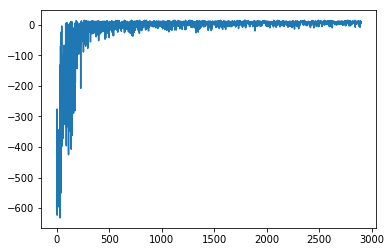

In [6]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

rewards = []
for i in range(3000):
    rewards.append(play_and_train(env, agent))
    
    agent.epsilon *= 0.999
    
    if i %100 ==0:
        clear_output(True)
        print("mean reward",np.mean(rewards[-100:]))
        plt.plot(rewards)
        plt.show()
        

In [7]:
env = gym.make("Taxi-v2")
frames = []

for j in range(10):  #10개 예제

    s = env.reset()

    for i in range(100000):
        video = env.render(mode='ansi')
        frames.append(video.getvalue())
        a = agent.getAction(s)
        next_s,r,done,_ = env.step(a)
        s = next_s

        if done:
            break

import time
for frame in frames:
    clear_output(True)
    print(frame)
    time.sleep(0.3)

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)



## Main Homework

agent를 사용해서 `CartPole-v0`를 효율적으로 training한다.

이 환경은 state들이 continuous한 숫자로 나타나서, discrete하게 state를 바꿔줘야한다.

가장 쉬운 방법은 `round(x, n_digits)`를 사용하여 state를 discrete하게 바꾸는 것이다.

Tricky한 부분은 각 state의 n_digits를 잘 결정해서 학습을 효율적으로 하는 것이다.

각 state에 대한 정보는 다음과 같다.

|Num	|Observation	|Min	|Max|
|:--:|:--|:--|:--|
|0	|Cart Position|	-2.4	|2.4|
|1	|Cart Velocity|	-Inf	|Inf|
|2	|Pole Angle	|~ -41.8°|	~ 41.8°|
|3	|Pole Velocity At Tip|	-Inf|	Inf|

In [139]:
env = gym.make("CartPole-v0")
n_actions = env.action_space.n
s = env.reset()
print(n_actions)
print(s)

[2017-07-10 22:21:56,829] Making new env: CartPole-v0


2
[ 0.00224153  0.00382006  0.03995311 -0.00391353]


In [140]:
agent = QLearningAgent(alpha=0.5,
                       epsilon=1,
                       discount=0.99,
                       getLegalActions=lambda s: range(n_actions))

scale_factors = [2, 10, 50, 20]

def play_and_train(env, agent, t_max=10**4):
    total_reward = 0.0
    states = env.reset()
    states = tuple(int(s * scale_factor) for s, scale_factor in zip(states, scale_factors))

    for t in range(t_max):
        action = agent.getAction(states)

        next_states, reward, done, _ = env.step(action)

        next_states = tuple(int(s * scale_factor) 
                       for s, scale_factor in zip(next_states, scale_factors))

        agent.update(states,
                     action,
                     next_states,
                     reward)
        
        states = next_states
        total_reward += reward
        if done:
            break
        
    return total_reward

mean reward 199.3


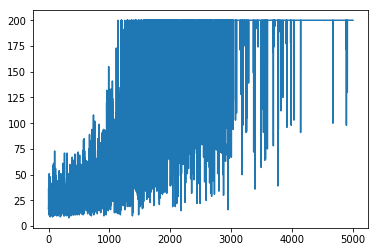

In [141]:

rewards = []
for i in range(5001):
    rewards.append(play_and_train(env, agent))
    if agent.epsilon < 1e-3:
        agent.epsilon = 0.0
    else:
        agent.epsilon *= 0.999
    if i % 500 ==0:
        clear_output(True)
        print("mean reward",np.mean(rewards[-100:]))
        plt.plot(rewards)
        plt.show()
        